In [6]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt 
#张量概念是矢量概念的推广，矢量是一阶张量。张量是一个可用来表示在一些矢量、
#标量和其他张量之间的线性关系的多线性函数(可以理解成是向量、矩阵以及更高维结构的统称)。
def show_single_image(img_arr):
    plt.imshow(img_arr,cmap="binary")
    plt.show()


# from tensorflow.examples.tutorials.mnist import input_data 老版本写法
# mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets
mnist = read_data_sets("MNIST_data/", one_hot=True)

tf.reset_default_graph()
# print(mnist)
# show_single_image(mnist.test.images[1])

sess = tf.InteractiveSession()

x = tf.placeholder("float", shape=[None, 784])
y_ = tf.placeholder("float", shape=[None, 10])


def weight_variable(shape):
#从截断的正态分布中输出随机值，生成的值服从具有指定平均值和标准偏差的正态分布，
#如果生成的值大于平均值2个标准偏差的值则丢弃重新选择
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
#一个类，初始化器，它生成具有常量值的张量。由新张量的期望shape后面的参数value指定。参数value可以是常量值，
#也可以是类型为dtype的值列表。如果value是一个列表，那么列表的长度必须小于或等于由张量的期望形状所暗示的元素的数量。
#如果值中的元素总数小于张量形状所需的元素数，则值中的最后一个元素将用于填充剩余的元素。如果值中元素的总数大于张量形状所需元素的总数，
#初始化器将产生一个ValueError。

    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)
#计算给定4-D输入和滤波器张量的2-D卷积.

"""
将滤镜展平为具有形状[filter_height * filter_width * in_channels, output_channels]的二维矩阵.
从输入张量中提取图像补丁,以形成形状为[batch, out_height, out_width, filter_height * filter_width * in_channels]的虚拟张量.
对于每个补丁,右对乘滤波器矩阵和图像补丁矢量.
"""
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding="SAME")

"""
max pooling是CNN当中的最大值池化操作，其实用法和卷积很类似
返回一个Tensor，类型不变，shape仍然是[batch, height, width, channels]这种形式
"""
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1],
                          strides=[1,2,2,1], padding="SAME")


W_conv1 = weight_variable([5,5,1,32])
b_conv1 = bias_variable([32])
print()
print("W_conv1,b_conv1是",W_conv1,b_conv1)

x_image = tf.reshape(x, [-1,28,28,1])
print()
print("x_image是",x_image)

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)
print()
print("h_conv1,h_pool1是",h_conv1,h_pool1)

W_conv2 = weight_variable([5,5,32,64])
b_conv2 = weight_variable([64])
print()
print(" W_conv2,b_conv2是", W_conv2,b_conv2)

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)
print()
print("h_conv2,h_pool2是",h_conv2,h_pool2)

W_fc1 = weight_variable([7*7*64, 1024])
b_fc1 = bias_variable([1024])
print()
print("W_fc1,b_fc1是",W_fc1,b_fc1)

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
#tf.nn.relu(features, name = None)：这个函数的作用是计算激活函数 relu，即 max(features, 0)。
#将大于0的保持不变，小于0的数置为0。
#tf.matmul：将矩阵a乘以矩阵b，生成a * b
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)



keep_prob = tf.placeholder("float")
#Dropout就是在不同的训练过程中随机扔掉一部分神经元 也就是让某个神经元的激活值以一定的概率p，
#让其停止工作，为了防止或减轻过拟合而使用的函数 keep_prob：概率
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob) #它一般用在全连接层

W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

#softmax函数将压缩每个类在0到1之间，并除以输出总和。它实际上可以表示某个类的输入概率。
y_conv = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)


#self.prediction = tf.nn.softmax(wx_plus_b2)


#tf.reduce_sum用于计算张量tensor沿着某一维度的和，可以在求和后降维。
cross_entropy = -tf.reduce_sum(y_ * tf.log(y_conv))

#tf.train.AdamOptimizer：此函数是Adam优化算法：是一个寻找全局最优点的优化算法，引入了二次方梯度校正。
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

#tf.equal：逐个元素进行判断，如果相等就是True，不相等，就是False
correct_predict = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
#tf.cast：tensorflow 中张量数据类型转换，比如读入的图片如果是int8类型的，
#一般在要在训练前把图像的数据格式转换为float32。
accuracy = tf.reduce_mean(tf.cast(correct_predict, "float"))

#tf.summary.scalar ：用来显示标量信息，一般在画loss,accuary时会用到这个函数
tf.summary.scalar('cross_entropy', cross_entropy)#
tf.summary.scalar('accuracy', accuracy)

sess.run(tf.initialize_all_variables())
#tfboard injection
#merge_all 可以将所有summary全部保存到磁盘，以便tensorboard显示。
#如果没有特殊要求，一般用这一句就可一显示训练时的各种信息了。
merged = tf.summary.merge_all()

"""
tf.summary.FileWriter:
指定一个文件用来保存图。
log是事件文件所在的目录，这里是工程目录下的log目录。第二个参数是事件文件要记录的图，也就是TensorFlow默认的图。
可以调用其add_summary()方法将训练过程数据保存在filewriter指定的文件中。
"""
writer = tf.summary.FileWriter("tblogs", sess.graph)

saver = tf.train.Saver(max_to_keep=1)  # 只保留最近一次的模型


for i in range(201):
    batch = mnist.train.next_batch(50)
    if i%100 == 0:
        train_accuracy = accuracy.eval(feed_dict={
            x:batch[0], y_:batch[1], keep_prob:1.0})
        print ("step %d, training accuracy %g" % (i, train_accuracy))
        summary,_ = sess.run([merged,train_step],feed_dict={x:batch[0], y_:batch[1], keep_prob:0.5})
        writer.add_summary(summary,i)
        
    else:
        train_step.run(feed_dict={x:batch[0], y_:batch[1], keep_prob:0.5})
    saver.save(sess, '/tmp/tf/mnist.ckpt')
writer.flush()
print ("test accuracy %g" % accuracy.eval(feed_dict={x:mnist.test.images, y_:mnist.test.labels, keep_prob:1.0}))


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz

W_conv1,b_conv1是 <tf.Variable 'Variable:0' shape=(5, 5, 1, 32) dtype=float32_ref> <tf.Variable 'Variable_1:0' shape=(32,) dtype=float32_ref>

x_image是 Tensor("Reshape:0", shape=(?, 28, 28, 1), dtype=float32)

h_conv1,h_pool1是 Tensor("Relu:0", shape=(?, 28, 28, 32), dtype=float32) Tensor("MaxPool:0", shape=(?, 14, 14, 32), dtype=float32)

 W_conv2,b_conv2是 <tf.Variable 'Variable_2:0' shape=(5, 5, 32, 64) dtype=float32_ref> <tf.Variable 'Variable_3:0' shape=(64,) dtype=float32_ref>

h_conv2,h_pool2是 Tensor("Relu_1:0", shape=(?, 14, 14, 64), dtype=float32) Tensor("MaxPool_1:0", shape=(?, 7, 7, 64), dtype=float32)


/usr/local/lib/python3.6/site-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '



W_fc1,b_fc1是 <tf.Variable 'Variable_4:0' shape=(3136, 1024) dtype=float32_ref> <tf.Variable 'Variable_5:0' shape=(1024,) dtype=float32_ref>
step 0, training accuracy 0.16
step 100, training accuracy 0.96
step 200, training accuracy 0.88
test accuracy 0.9243


# train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
本训练是对AdamOptimizer优化器 运行coss为cross_entropy的优化过程

In [7]:
saver = tf.train.Saver()
sess = tf.Session() 
saver.restore(sess, "/tmp/tf/mnist.ckpt")

INFO:tensorflow:Restoring parameters from /tmp/tf/mnist.ckpt


In [5]:
from PIL import Image, ImageFilter
import tensorflow as tf
import matplotlib.pyplot as plt

def imageprepare(): 
    im = Image.open('/root/code/3.jpg') #读取的图片所在路径，注意是28*28像素
    plt.imshow(im)  #显示需要识别的图片
    plt.show()
    im = im.convert('L')
    tv = list(im.getdata()) 
    tva = [(255-x)*1.0/255.0 for x in tv] 
    return tva

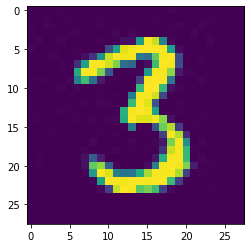

[0.996078431372549,
 1.0,
 1.0,
 1.0,
 0.9921568627450981,
 1.0,
 1.0,
 0.996078431372549,
 0.996078431372549,
 1.0,
 0.996078431372549,
 1.0,
 1.0,
 1.0,
 1.0,
 0.996078431372549,
 1.0,
 1.0,
 0.9882352941176471,
 1.0,
 0.996078431372549,
 1.0,
 0.996078431372549,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9921568627450981,
 1.0,
 0.996078431372549,
 0.9921568627450981,
 0.996078431372549,
 1.0,
 1.0,
 0.996078431372549,
 1.0,
 1.0,
 0.996078431372549,
 0.996078431372549,
 0.996078431372549,
 1.0,
 0.9921568627450981,
 1.0,
 1.0,
 1.0,
 1.0,
 0.996078431372549,
 1.0,
 0.9921568627450981,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9921568627450981,
 1.0,
 0.9882352941176471,
 0.996078431372549,
 1.0,
 1.0,
 1.0,
 1.0,
 0.996078431372549,
 0.9921568627450981,
 1.0,
 1.0,
 0.996078431372549,
 1.0,
 0.996078431372549,
 1.0,
 1.0,
 1.0,
 0.996078431372549,
 0.9882352941176471,
 1.0,
 1.0,
 0.984313725490196,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.996078431372549,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9921568627450981,
 

In [6]:
imageprepare()

In [11]:
sess

In [13]:
from PIL import Image
import numpy as np
def predict_mnist(xs):
    predicts = []
    for image_path in xs :
        img = Image.open(image_path).convert('L')
        x = np.reshape(img, [1, 784])
        y = sess.run(y_conv, feed_dict={x: x,keep_prob: 1.0})
        predicts.appenda(str(y))
        print(image_path)
        print(' Predict digit', np.argmax(y[0]))  # 提取出可能性最大的值
    return predicts
 
xs = ["/root/code/3.jpg"]
predict_mnist(xs)

TypeError: unhashable type: 'numpy.ndarray'

In [24]:
from PIL import Image
import numpy as np
def predict( image_path):
        # 读取图片并灰度化
        img = Image.open(image_path).convert('L')
        x = np.reshape(img, [1, 784])
        y = sess.run(y_conv, feed_dict={x})

        print(image_path)
        print(' Predict digit', np.argmax(y[0]))  # 提取出可能性最大的值
 
# xs = ["/root/code/3.jpg"]
predict('/root/code/3.jpg')  # 单张图片路径

TypeError: unhashable type: 'numpy.ndarray'